In [1]:
import sys
sys.path.insert(1,'../')

In [2]:
import torch.backends.cudnn as cudnn
import torch
import numpy as np
from tqdm import tqdm
from copy import deepcopy
import torchvision.transforms as T

In [3]:
from data.dataloader import ImageNetA, get_dataloader
from utils.utils import set_random_seed, parse_args
from data.datautils_TPT import Augmenter
from model.custom_clip import get_coop

set_random_seed(1234)
sys.argv = ['','--ImageNetA_path', '../../Datasets/imagenet-a/', 
                '--coop_weight_path', '../../model.pth.tar-50',
                '--n_aug', '10',
           ]
args = parse_args()

In [4]:
args

Namespace(ImageNetA_path='../../Datasets/imagenet-a/', coop_weight_path='../../model.pth.tar-50', n_aug=10, n_patches=16, batch_size=1, arch='RN50', device='cuda:0', learning_rate=0.005, weight_decay=0.0005, momentum=0.9, n_ctx=4, ctx_init='', class_token_position='end', csc=False, selected_augmenter='TPTAgumenter')

In [5]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import math

def show(imgs, label=None):
    if not isinstance(imgs, list):
        imgs = [imgs]

    num_imgs = len(imgs)
    num_cols = min(4, num_imgs)
    num_rows = math.ceil(num_imgs / num_cols)

    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(3*num_cols, 3 * num_rows))

    if label is not None:
        fig.suptitle(f"Label: {label}", fontsize=16)
        
    if num_imgs > 1:
        axs = axs.flatten()
    else:
        axs = [axs]

    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[i].imshow(np.asarray(img))
        axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    # Hide any unused subplots
    for j in range(i + 1, num_rows * num_cols):
        axs[j].axis('off')

## get data

In [6]:
classnames = ImageNetA.classnames
dataset = ImageNetA(args.ImageNetA_path)

image_idx = 150
(img, label_idx) = dataset[image_idx]
label = classnames[label_idx]

print(label)

goldfinch


## Show transformation

### original image

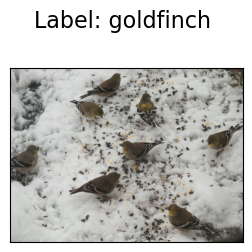

In [7]:
img_tensor = T.PILToTensor()(img)
show(img_tensor, label)

### CLIP preprocess only

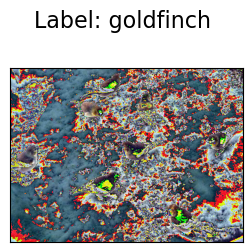

In [8]:
clip_preprocess = T.Compose(
            [
                T.ToTensor(),
                T.Normalize(
                    mean=[0.48145466, 0.4578275, 0.40821073],
                    std=[0.26862954, 0.26130258, 0.27577711],
                ),
            ]
        )
img_clip_prep = clip_preprocess(img)
show(img_clip_prep, label)

### CLIP preprocess only + base transform

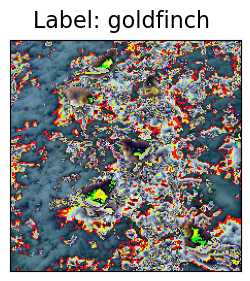

In [9]:
from torchvision.transforms import InterpolationMode
BICUBIC = InterpolationMode.BICUBIC

base_transform = T.Compose(
            [
                T.Resize(224, interpolation=BICUBIC),
                T.CenterCrop(224),
            ]
        )
img_clip_prep_base_transform = clip_preprocess(base_transform(img))
show(img_clip_prep_base_transform, label)

### Augmenter, augmix = False

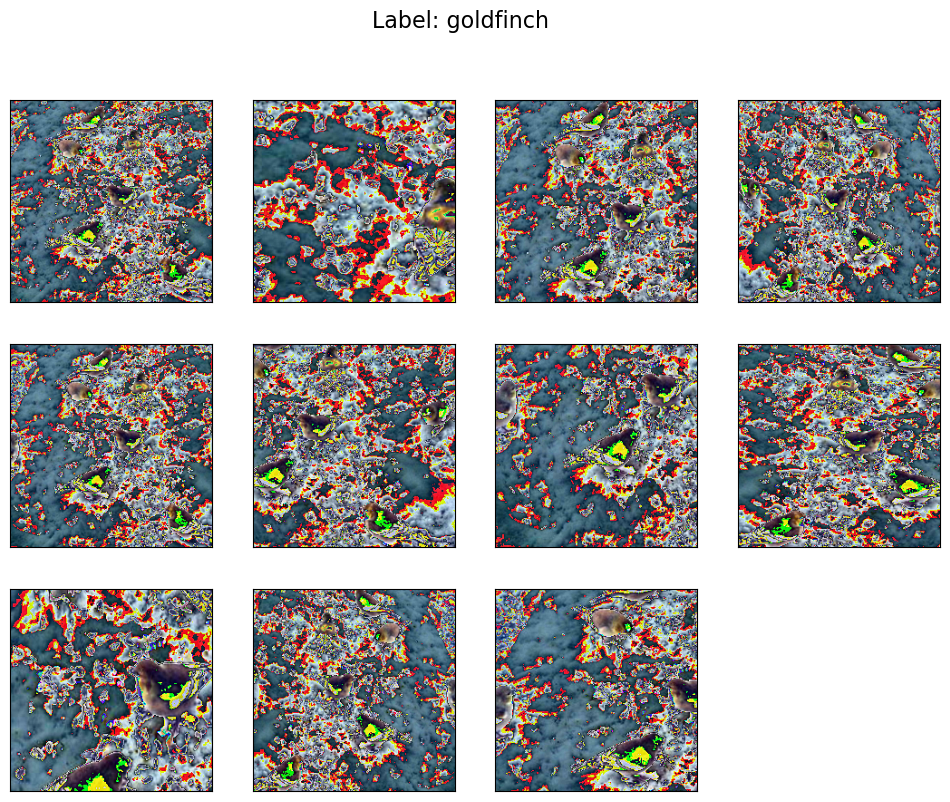

In [10]:
augmenter = Augmenter(n_aug=args.n_aug, augmix=False)
imgs_augmix_f = augmenter(img)

assert(torch.equal(img_clip_prep_base_transform, imgs_augmix_f[0]))

show(imgs_augmix_f, label)

### Augmenter, augmix = True

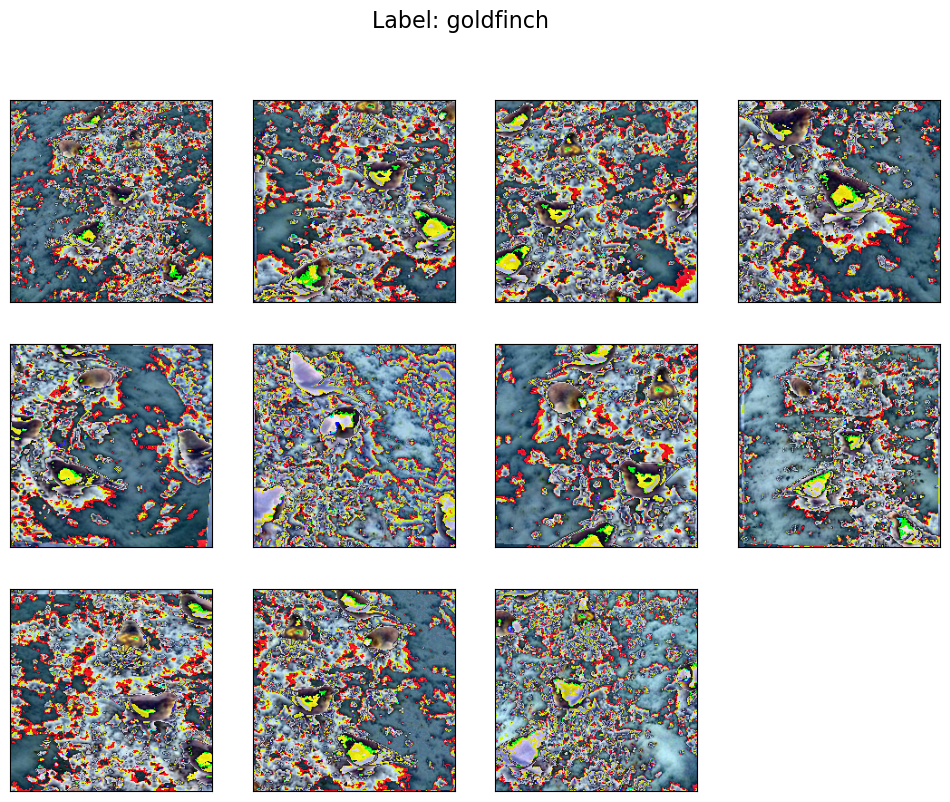

In [11]:
augmenter = Augmenter(n_aug=args.n_aug, augmix=True)
imgs_augmix_t = augmenter(img)
show(imgs_augmix_t, label)

### Our Aumenter, patch only

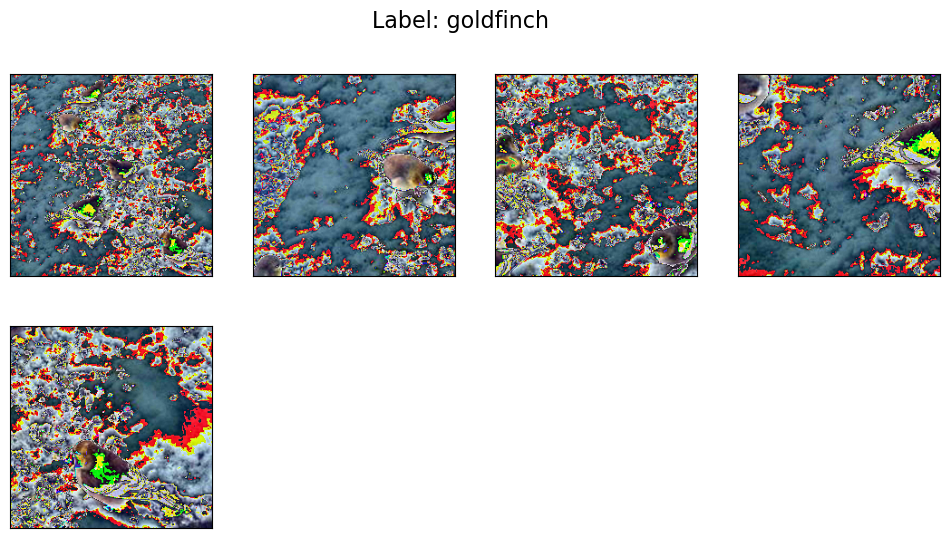

In [12]:
from data.datautils import PatchAugmenter

patch_only_augmenter = PatchAugmenter(n_aug=0, n_patches=2)
imgs_patches = patch_only_augmenter(img)
show(imgs_patches, label)

### Our Aumenter, patch and augment

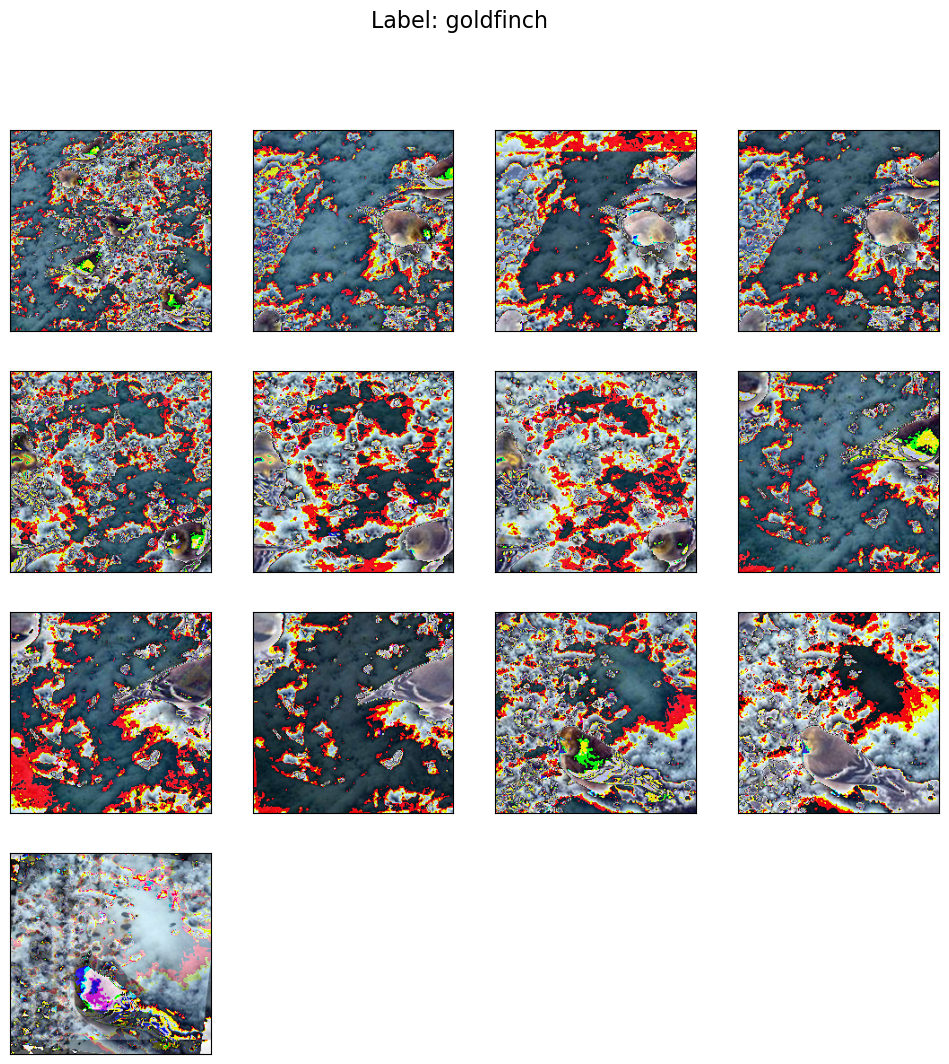

In [13]:
patch_only_augmenter = PatchAugmenter(n_aug=2, n_patches=2)
imgs_patches = patch_only_augmenter(img)
show(imgs_patches, label)